In [49]:
home = "dbfs:/mnt/data"
activityDataSample = f"{home}/data/activity-data"

## Stream Processing Fundamentals

-  **Streaming Processing**:
    -  continuously incorporating new data to compute results
    -  input data in unbounded (no beginning or end)
    -  Use Cases (alerts, real-time transaction reporting, incremental ETL, online ML)
    -  Challenges (input records might arrive out of order [timestamps], handling machine failures, joining with other data) sources   
    <br>
    -  **Event-Time vs Processing Time**:
        -  ET (process data based on timestamp records within source data)
        -  PT (process data based on when streaming application receives records)   
        <br>
    -  **Continuous Processing vs Micro-Batch Execution**:
        -  CP (read records one by one from input source for low latency benefits)
        -  MBE (read records in small batches from input source for higher throughput benefits but higher latency)

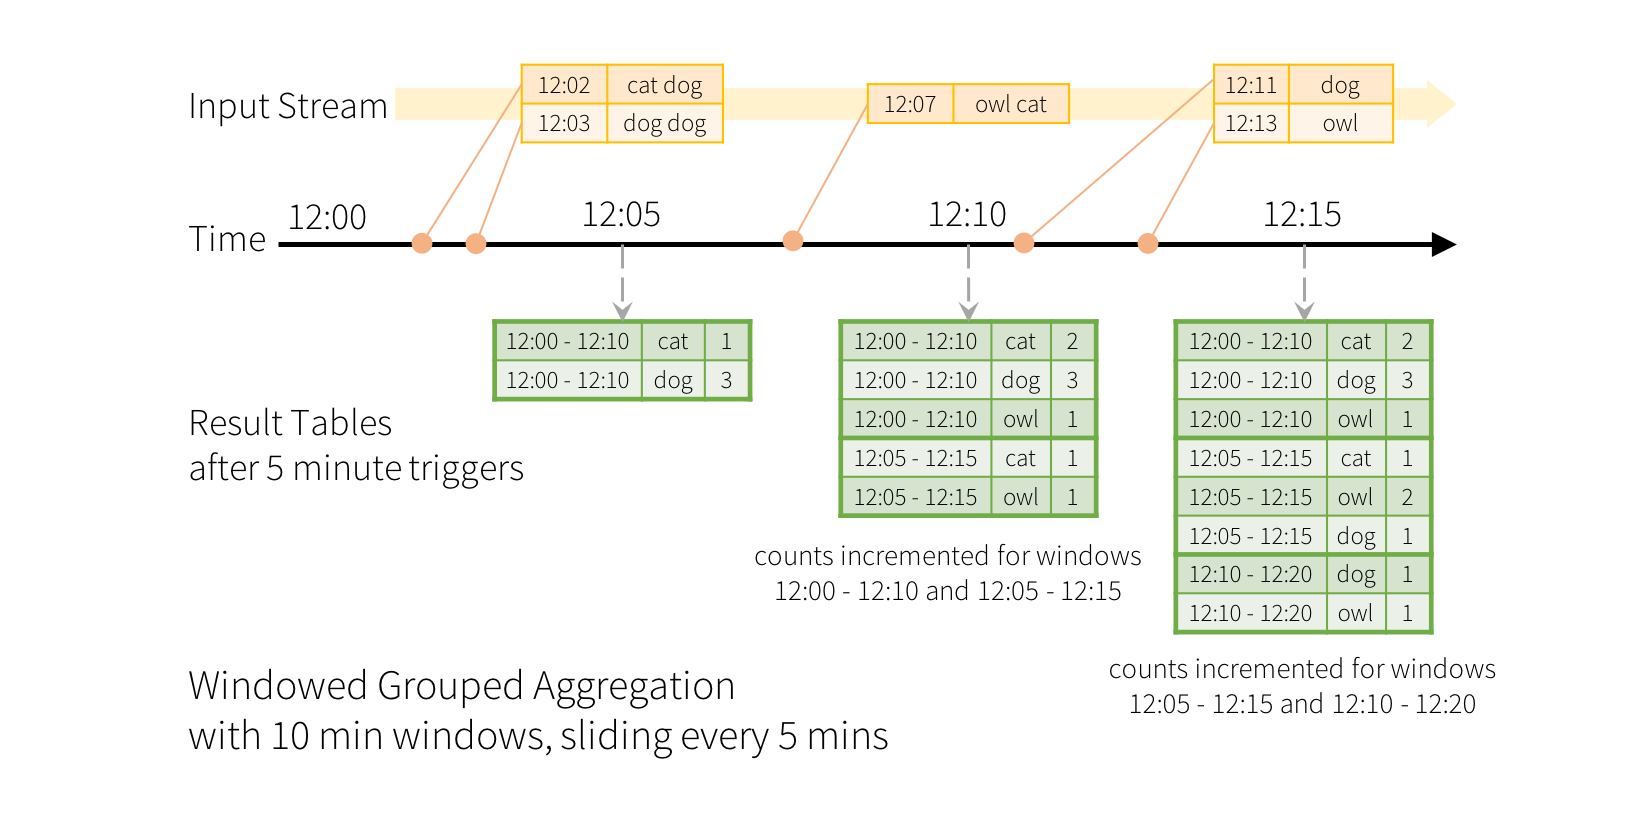

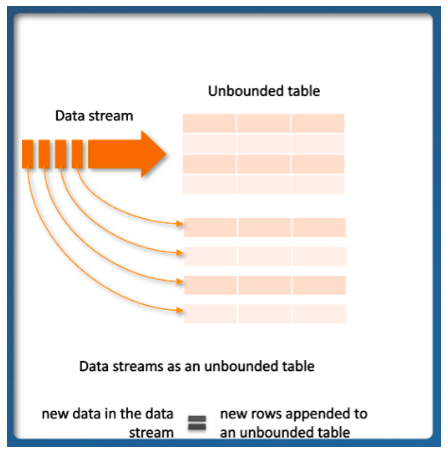

## Structured Streaming Basics

-  SS engine computes a switch for running queries incrementally and continuously as new data arrives into the system
-  SS ensures data processed once as well as fault-tolerance through checkpointing
-  SS treats a stream as a "table" that is continuously appended and periodically checks for new data flowing through active streams to update new results
-  SS supports Spark Transformations and Actions (starting a stream)

-  **Structured Streaming Features**:
    -  **Input Sources (streams source entry point)**:
         -  Kafka
         -  distributed file system (HDFS, S3)
         -  socket for testing purposes  
         <br>
    -  **Sinks (streams target result destination)**:
         -  Kafka
         -  many file formats
         -  foreach sink for running arbitary computation on the output records
         -  console sink for testing
         -  memory sink for debugging   
         <br>
    -  **Output Modes (how to write data to sink)**:
         -  Append (only add new records to output sink based on trigger; does not support aggregations because of logic)
         -  Update (update changed records in place [rows different from previous write are written out to sink])
         -  Complete (rewrite full output to result table [useful for data where all rows are expected to change])   
         <br>
    -  **Triggers**:
        - frequency when data is outputed to sink
        -  ex: trigger duration of 1 min will fire at 12:00, 12:01, 12:02, etc.
        <br>

### Sources and Sinks:
-  File Source & Sink 
<br>
-  Kafka Source & Sink
    -  Acts as a distributed buffer
    -  Stores streams of records in categories called _topics_
    -  Each record consists of a key, a value, and a timestamp
    -  Reading data is called subscribing to a topic and writing data is called publishing to a topic   
    <br>
-  Socket Source
    -  Ability to send data to streams via TCP sockets

## Structured Streaming in Action
- For our examples, we’re going to be working with the Heterogeneity Human Activity Recognition Dataset
- The data consists of smartphone and smartwatch sensor readings from a variety of devices—specifically, the accelerometer and gyroscope, sampled at the highest possible frequency supported by the devices.
- Readings from these sensors were recorded while users performed activities like biking, sitting, standing, walking, and so on
- There are several different smartphones and smartwatches used, and nine total users

In [50]:
static = spark.read.json(activityDataSample)

In [51]:
dataSchema = static.schema

In [52]:
static.printSchema()

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [53]:
static.show(3, truncate=True)

+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|           x|           y|           z|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
|1424686735090|1424686733090638193|nexus4_1|   18|nexus4|   g|stand| 3.356934E-4|-5.645752E-4|-0.018814087|
|1424686735292|1424688581345918092|nexus4_2|   66|nexus4|   g|stand|-0.005722046| 0.029083252| 0.005569458|
|1424686735500|1424686733498505625|nexus4_1|   99|nexus4|   g|stand|   0.0078125|-0.017654419| 0.010025024|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
only showing top 3 rows



- You can see in the preceding example, which includes a number of timestamp columns, models, user, and device information
- The gt field specifies what activity the user was doing at that time.

## Streaming version
- Next, let’s create a streaming version of the same Dataset, which will read each input file in the dataset one by one as if it was a stream.
- You can enable schema inference for this by setting the configuration spark.sql.streaming.schemaInference to true

In [54]:
spark.conf.set("spark.sql.streaming.schemaInference", True)

In [55]:
#streaming = spark.readStream.schema(dataSchema).option("maxFilesPerTrigger", 1).json(activityDataSample)

streaming = spark.readStream.option("maxFilesPerTrigger", 1).json(activityDataSample)

- Group and count data by the gt column, which is the activity being performed by the user at that point in time

In [56]:
activityCounts = streaming.groupBy("gt").count()

In [57]:
spark.conf.set("spark.sql.shuffle.partitions", 5)

- Now that we set up our transformation, we need only to specify our action to start the query
- We will specify an output destination, or output sink for our result of this query
- We are going to write to a memory sink which keeps an in-memory table of the results.

In [58]:
activityQuery = activityCounts.writeStream.queryName("activity_counts")\
.format("memory").outputMode("complete").start()

- We are now writing out our stream
- You’ll notice that we set a unique query name to represent this stream, in this case activity_counts
- After this code is executed, the streaming computation will have started in the background

In [59]:
#activityQuery.stop()

- Spark lists this stream, and other active ones, under the active streams in our SparkSession
- We can see a list of those streams by running the following

In [60]:
spark.streams.active

- Spark also assigns each stream a UUID, so if need be you could iterate through the list of running streams and select the above one
- In this case, we assigned it to a variable, so that’s not necessary.
- Now that this stream is running, we can experiment with the results by querying the in-memory table it is maintaining of the current output of our streaming aggregation
- This table will be called activity_counts, the same as the stream
- To see the current data in this output table, we simply need to query it! We’ll do this in a simple loop that will print the results of the streaming query every second:

In [61]:
from time import sleep
for x in range(3):
    spark.sql("select * from activity_counts").show(3)
    sleep(2)

+---+-----+
| gt|count|
+---+-----+
+---+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|86154|
|     stand|79700|
|stairsdown|65539|
+----------+-----+
only showing top 3 rows

+----------+------+
|        gt| count|
+----------+------+
|       sit|172309|
|     stand|159395|
|stairsdown|131087|
+----------+------+
only showing top 3 rows



In [62]:
from pyspark.sql.functions import expr

### _Select & Filter Example_

- In this case, because we are not updating any keys over time, we will use the Append output mode, so that new results are appended to the output table:

In [63]:
simpleTransform = streaming.withColumn("stairs", expr("gt like '%stairs%'"))\
.where("stairs")\
.where("gt is not null")\
.select("gt", "model", "arrival_time", "creation_time")\
.writeStream\
.queryName("simple_transform")\
.format("memory")\
.outputMode("append")\
.start()

In [64]:
#simpleTransform.stop()

In [65]:
from time import sleep
for x in range(3):
    spark.sql("select count(*) from simple_transform").show()
    sleep(1)

+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|   39635|
+--------+

+--------+
|count(1)|
+--------+
|  118904|
+--------+



### Triggers
- To control when data is output to our sink, we set a trigger
- By default, Structured Streaming will start data as soon as the previous trigger completes processing
- You can use triggers to ensure that you do not overwhelm your output sink with too many updates or to try and control file sizes in the output.

#### Processing time trigger
- For the processing time trigger, we simply specify a duration as a string
- The ProcessingTime trigger will wait for multiples of the given duration in order to output data
- For example, with a trigger duration of one minute, the trigger will fire at 12:00, 12:01, 12:02, and so on.
- If a trigger time is missed because the previous processing has not yet completed, then Spark will wait until the next trigger point (i.e., the next minute), rather than firing immediately after the previous processing completes

In [66]:
trigger = activityCounts.writeStream.trigger(processingTime = '5 seconds')\
.queryName("t1").format("console").outputMode("complete").start()

#### Once trigger
- You can also just run a streaming job once by setting that as the trigger

In [67]:
triggerOnce = activityCounts.writeStream.trigger(once=True)\
.queryName("t2").format("console").outputMode("complete").start()

In [68]:
spark.streams.active

In [69]:
activityQuery.stop()
simpleTransform.stop()
trigger.stop()
triggerOnce.stop()

In [70]:
spark.streams.active

[]